# TO·Pi·cks:

## Forecast Consumer-Interest in Topics

__Author: Tarun Gupta  
  Company: Insight Data Science  
  Location: Toronto, ON__   
  Date: Januray 2019  
  Github: https://github.com/tguptaMT/TOPicks  
  __About:__ Powered by NLP and machine-learning based time-series forecasting, TO·Pi·cks is a consumer-engagement and popularity forecasting tool. See ReadMe file for more details. 
  
  _This is the __fourth and the last__ notebook in a series of Jupyter notebooks associated with TOPicks. There are additional .py modules required for web deployment._

### Step4: User-IO:

- __Load:__
    - Models:
        - load trained word2vec model for finding synonyms to user-typed keyword.
        - load trained NMF model to match user input to topics.
    - Data:
        - load predictions made by time-series forecasting model
- __ Input:__
    - Ask the user to input 3 potential topics of interest.
    - OR Choose from 3 different drop-down menus.
- __Process:__
    - Find related topics by w2v.
    - Match user-input to topic cluster
    - repeat for all inputs
- __Output:__
    - Display comparative weekly predictions for all inputs over the next 2 months.

In [12]:
import gensim
from gensim.models import Word2Vec
from joblib import load
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load Data and Models:

In [10]:
try:  
    ############## load previously trained models ##############
    # word2vec model for synonyms:
    w2v = Word2Vec.load("model/word2vec/w2v_bigram.model")
    # NMF topic models for matching user input to topics:
    nmf = load('model/nmf/latest_nmf_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib') 
    vectorizer = load('model/nmf/latest_tfidf_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib')

    # import data containing topic assignments from Step2:
    tp_name = 'data/parquet_data/step2_NMF_topics=200_assigned.parquet'
    pilot = pd.read_parquet(tp_name, engine='pyarrow')
    all_topics = pilot['topic_name'].unique()

    # File with time-series analytics for that topic:
    ts_name = 'data/ts_predictions/all_preds_ts_gb_hptuning=False_nmf_ntopics=198.parquet'
    predictions = pd.read_parquet(ts_name, engine='pyarrow')
except:
    print("One of the required models / data files not found.")
    

### User Input:

When a new headline or a topic is entered by the user, feed it through pretrained word2vec to find similar embeddings (Top10 similar words). Then use those to create a sentence / document of highly related words to feed into tfidf-nmf pipeline for matching user-input to the list of predicted topics within our corpus. This process will increase mapping specificity.

Some Topic Suggestions to get you started:
 Law, Tax, climate change, Ebola, guns, Russia, Mexico, Phone..



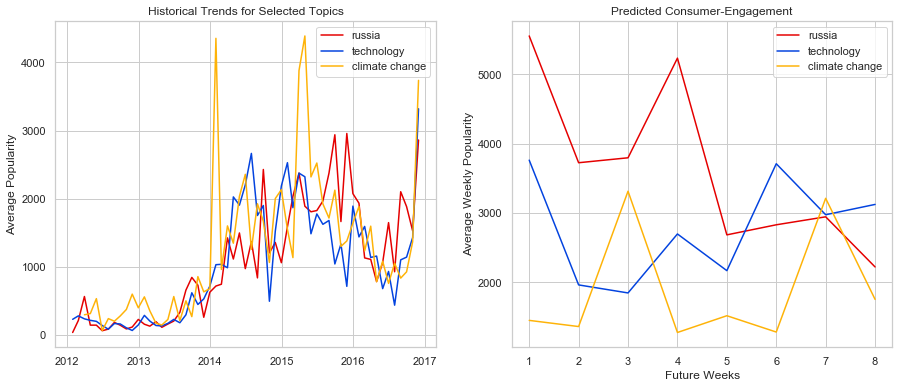



You might also be interested in these related topics:
 ['smartphones', 'nato', 'crimea', 'looming', 'climate', 'gadget', 'putin', 'device', 'warming', 'assad']


In [173]:

#######################################################################
# HAVE A USER ENTER A TOPIC OF INTEREST. FIND SIMILAR TOPICS
## in order to map to popularity and user-engagement data for related topics.
#######################################################################
print("Some Topic Suggestions to get you started:\n Law, Tax, climate change, Ebola, guns, Russia, Mexico, Phone..\n")
user_inputs, all_related_topics = [], []
for i in range(3):
    user_inputs.append(input("Enter topic # {} of interest: ".format(str(i+1))).lower())
    
for uinput in user_inputs:
    try:
        user2similar = w2v.wv.most_similar(positive=uinput,topn=10)
    except KeyError:
        try:
            user2similar = w2v.wv.most_similar(positive=uinput[:-1],topn=10)
        except KeyError:
            try:
                user2similar = w2v.wv.most_similar(positive=uinput[:-2],topn=10) #convert eg. taxes to tax
            except KeyError:
                print("Sorry, we currently do not have data for - {}, Try a different topic.".
                  format(uinput))
                user2similar = ''
            pass
        pass

    all_related_topics.append([x for x in list(sum(user2similar, ())) if str(x).isalpha()])

#######################################################################
# QUERY AGAINST INTERNAL TOPICS FOR FORECASTING
#######################################################################
matched_topics=[]
for related_topics in all_related_topics:
    
    # Transform user-input and highly-similar topics to match with topic data:
    user_nmf = nmf.transform(vectorizer.transform([" ".join(related_topics)]))[0]
    matched_topics.append(user_nmf.argmax())

    # for debugging and internal topic matching: don't show to the user:
    #print("\n- Likely forecast topic #", matched_topic, ":\t", all_topics[matched_topic],)


utopics = {}
for topic in matched_topics:
    utopics[topic] = pilot[pilot['predicted_topic'] == topic].set_index('date')\
                                                                      ['likes_count'].resample('W').mean()                                                                   .resample('M').median()

# upreds = {}
# for topic in matched_topics:
#     upreds[topic] = predictions[predictions['predicted_topic'] == topic]['likes_count']\
#                                                                      .resample('M').median()

#######################################################################
# PLOT HOW POPULAR/ENGAGING THAT TOPIC HAS BEEN PER MONTH
#######################################################################
sns.set(style="whitegrid")
colors = ["red", "blue", "amber"]
sns.set_palette(sns.xkcd_palette(colors))

fig1, ax = plt.subplots(figsize=(15,6))
ax=plt.subplot(121)
try:
    for key, v in utopics.items():
        label_ = [each[0] for each in zip(user_inputs, matched_topics) if key in each][0]
        ax.plot(v, label=label_)
    ax.set_title("Historical Trends for Selected Topics")
    ax.set_ylabel("Average Popularity")
    plt.legend()

    ax=plt.subplot(122)
    for key in utopics.keys():
        v = predictions[predictions['predicted_topic']==key][-8:].reset_index()\
            ['preds_likes_gb']
        label_ = [each[0] for each in zip(user_inputs, matched_topics) if key in each][0]
        ax.plot(v, label=label_)
    ax.set_title("Predicted Consumer-Engagement")
    ax.set_xlabel("Future Weeks")
    ax.set_ylabel("Average Weekly Popularity")
    ax.set_xticklabels(list(range(0,9)))
    plt.legend()
    plt.show()
except IndexError:
    pass

related_subset = random.sample(sum(all_related_topics, []), 10)
print("\n\nYou might also be interested in these related topics:\n", related_subset)